In [9]:
%matplotlib inline
import numpy as np
from numpy.random import uniform, seed
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import warnings
from time import sleep
from scipy.spatial.distance import cdist

In [10]:
warnings.filterwarnings('ignore')
seed(42)

In [11]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)  
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)  
plt.rc('ytick', labelsize=SMALL_SIZE)

## 2D Cluster Demo

In [12]:
def sample_clusters(n_points=500, n_dimensions=2, n_clusters=5, 
                    cluster_std=1):
    data, labels = make_blobs(n_samples=n_points, 
                               n_features=n_dimensions, 
                               centers=n_clusters, 
                               cluster_std=cluster_std, 
                               random_state=42)
    return data, labels

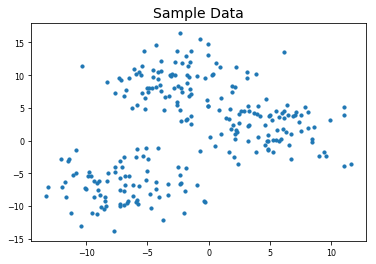

In [13]:
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=3, cluster_std=3)
x, y = data.T

plt.figure()
plt.scatter(x, y, s=10)
plt.title('Sample Data', fontsize=14);

## K-Means Implementation

### Assign Points to closest Centroid

In [14]:
def assign_points(centroids, data):
    dist = cdist(data, centroids)        # all pairwise distances
    assignments = np.argmin(dist, axis=1)   # centroid with min distance
    return assignments

### Move Centroids to best represent Clusters

In [15]:
def optimize_centroids(data, assignments):
    data_combined = np.column_stack((assignments.reshape(-1, 1), data))
    centroids = pd.DataFrame(data=data_combined).groupby(0).mean()
    return centroids.values

### Measure Distance from Points to Centroids

In [16]:
def distance_to_center(centroids, data, assignments):
    distance = 0
    for c, centroid in enumerate(centroids):
        assigned_points = data[assignments == c, :]
        distance += np.sum(cdist(assigned_points, centroid.reshape(-1, 2)))
    return distance

### Plot Clusters Dynamically

In [17]:
def plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step, ax, delay=2):
    ax.clear()
    ax.scatter(x, y, c=labels, s=15)
    # plot cluster centers
    centroid_x, centroid_y = centroids.T
    ax.scatter(*centroids.T, marker='o',  c='w', s=200, 
               edgecolor='k', zorder=9)
    for label, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker='${}$'.format(label), s=50, 
                   edgecolor='k', zorder=10)
    # plot links to cluster centers
    for i, label in enumerate(assignments):
        ax.plot([x[i], centroid_x[label]], [y[i], centroid_y[label]], 
                ls='--', color='white', lw=0.5)
    
    ax.set_title('Iteration: {} | {} | Inertia: {:,.2f}'.format(iteration, 
                                        step,  distance), fontsize=14)
    fig.canvas.draw()
    sleep(delay)

### Run K-Means Experiment

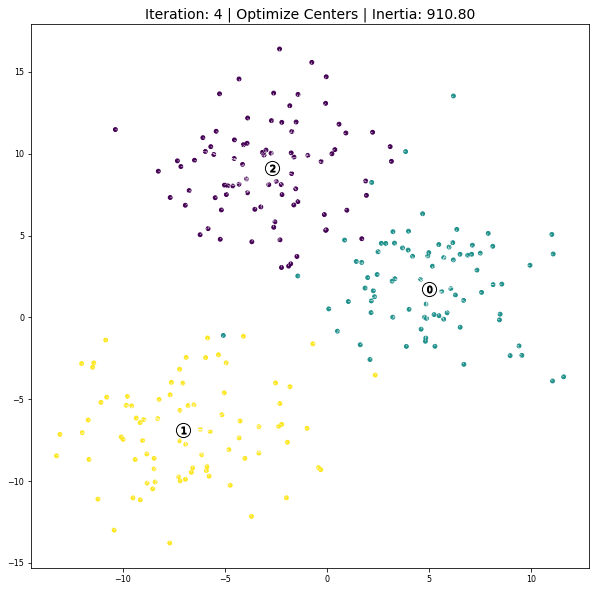

In [21]:
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=n_clusters, cluster_std=3)
x, y = data.T

x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))
distance = np.sum(np.min(cdist(data, centroids), axis=1))

fig, ax = plt.subplots(figsize=(10,10))
iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step='Assign Points', ax=ax)
    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta
    plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step='Optimize Centers', ax=ax)
    iteration += 1

### Plot Voronoi Tesselation

In [19]:
def plot_voronoi(x, y, labels, centroids, assignments, distance, iteration, step, ax, delay=1):
    ax.clear()
    ax.scatter(x, y, c=labels, s=15)
    # plot cluster centers
    ax.scatter(*centroids.T, marker='o',  c='w', s=200, edgecolor='k', zorder=9)
    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker='${}$'.format(i), s=50, 
                   edgecolor='k', zorder=10)   

    # plot links to centroid
    cx, cy = centroids.T
    for i, label in enumerate(assignments):
        ax.plot([x[i], cx[label]], [y[i], cy[label]], ls='--', 
                color='white', lw=0.5)
    
    # plot voronoi
    xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), 
                         np.arange(y.min() - 1, y.max() + 1, .01))
    Z = assign_points(centroids, np.c_[xx.ravel(),  yy.ravel()]).reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
       cmap=plt.cm.viridis, aspect='auto', origin='lower', alpha=.2)
    
    ax.set_title('Iteration: {} | {} | Distance: {:,.1f}'.format(iteration, step, distance))
    fig.canvas.draw()
    sleep(delay)

### Run Voronoi Experiment

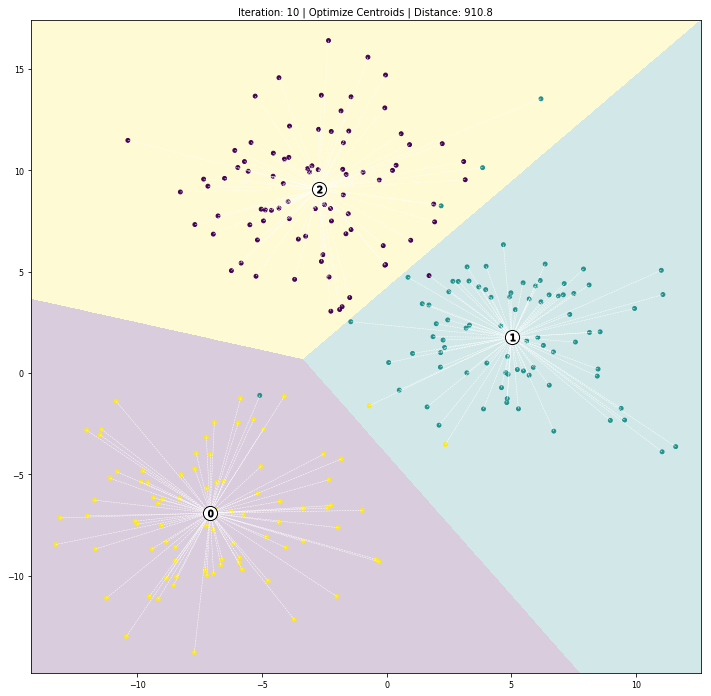

In [20]:
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, 
                               n_clusters=n_clusters, cluster_std=3)
x, y = data.T

x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))
distance = np.sum(np.min(cdist(data, centroids), axis=1))

fig, ax = plt.subplots(figsize=(12,12))
iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_voronoi(x, y, labels, centroids, assignments, distance, 
                 iteration, step='Assign Data', ax=ax)
    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta
    plot_voronoi(x, y, labels, centroids, assignments, distance, 
                 iteration, step='Optimize Centroids', ax=ax)
    iteration += 1